**Created on 05/01/2022**

**Group 2**

**Authors: LaurianeBompay**

**License: this code is released under the CeCILL 2.1 license. See
https://www.cecill.info/licenses/Licence_CeCILL_V2.1-en.txt**


In [9]:
import os
import sys
import math
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SequentialFeatureSelector

In [10]:
sns.set_style('darkgrid')

In [94]:
#data importation 
data_1 = pd.read_csv("data_v6.csv")
#data_0 = pd.read_csv("positions.csv")

Il faudra changer l'imporation des données quand on aura le jeu de données avec les changements de repaires.

In [95]:
data_1.describe()

,target,nlos_indicator,t1,t2,t3,t4,skew,tof,tof_skew,range,...,loc_target_x,loc_target_y,loc_target_z,temperature_initiator,temperature_target,rssi_request,rssi_ack,rssi_data,rssi_mean,orientation
count,3946.000000,3946.000000,3.946000e+03,3.946000e+03,3.946000e+03,3.946000e+03,3946.000000,3946.000000,3946.000000,3946.000000,...,3946.000000,3946.000000,3946.000000,3946.000000,3946.000000,3946.000000,3946.000000,3946.000000,3946.000000,3946.000000
mean,148.315256,7.215384,5.505930e+11,5.509284e+11,5.510320e+11,5.506966e+11,-2.755970,999.946275,1142.269047,4.690093,...,1.452085,5.878422,2.651427,39.577380,39.555326,-81.090100,-80.970815,-80.836828,-80.965914,81.495692
std,35.805126,19.476255,3.164409e+11,3.164412e+11,3.164412e+11,3.164409e+11,3.762459,674.344209,646.710484,3.162907,...,5.091560,2.249992,0.003063,2.341864,3.782210,5.635798,5.072976,4.818267,5.131755,96.093454
min,100.000000,0.000000,6.062043e+07,2.633300e+08,3.679996e+08,1.652910e+08,-11.659438,-613.000000,-152.480214,-2.875181,...,-3.962000,2.793000,2.650000,30.410000,27.559999,-120.000000,-120.000000,-120.000000,-120.000000,0.000000
25%,101.000000,2.956510,2.778704e+11,2.782606e+11,2.783633e+11,2.779731e+11,-5.783573,655.250000,715.863760,3.073348,...,-3.132000,4.339000,2.650000,38.959999,36.680000,-79.967224,-79.988684,-79.884079,-79.886862,0.000000
50%,171.000000,3.524929,5.528798e+11,5.532044e+11,5.533074e+11,5.529824e+11,-1.784294,898.000000,998.316717,4.211930,...,-1.190000,4.578000,2.650000,40.384998,39.340000,-79.230034,-79.305238,-79.218111,-79.237715,90.000000
75%,180.000000,4.342234,8.238901e+11,8.243201e+11,8.244236e+11,8.239937e+11,0.338401,1222.000000,1355.367840,5.731602,...,6.169000,7.931000,2.650000,41.240002,42.380001,-78.659598,-78.701023,-78.666953,-78.686799,119.000000
max,184.000000,342.462982,1.099128e+12,1.099376e+12,1.099479e+12,1.099231e+12,4.829899,2636.000000,2860.190262,12.363750,...,11.442000,9.249000,2.658000,42.380001,47.320004,-77.162437,-77.516188,-77.428716,-77.478065,270.000000


In [96]:
data_1.head()

,target,nlos_indicator,t1,t2,t3,t4,skew,tof,tof_skew,range,...,loc_target_x,loc_target_y,loc_target_z,temperature_initiator,temperature_target,rssi_request,rssi_ack,rssi_data,rssi_mean,orientation
0,100,2.783982,946218857614,946490292658,946594234510,946322802711,-2.368804,1622,1745.608935,7.607739,...,-3.962,7.931,2.65,30.98,30.220001,-80.136574,-80.077130,-79.836296,-80.016667,270.0
1,100,2.920485,1009474709646,1009746235572,1009850439822,1009578917162,-1.045965,1633,1687.497019,7.659333,...,-3.962,7.931,2.65,30.98,29.840002,-80.267769,-79.988684,-79.835720,-80.030724,270.0
2,100,2.536090,1072923068046,1073194681670,1073299179662,1073027569304,-0.799856,1633,1674.791667,7.659333,...,-3.962,7.931,2.65,30.98,29.840002,-79.964310,-79.850138,-79.693502,-79.835983,270.0
3,100,2.857669,36731534990,37003232943,37107270798,36835576116,-0.984438,1635,1686.709409,7.668714,...,-3.962,7.931,2.65,30.98,29.840002,-80.040833,-79.818313,-79.849525,-79.902890,270.0
4,100,2.263103,99923195534,100194974620,100298828942,100027053147,-0.769092,1645,1685.436774,7.715617,...,-3.962,7.931,2.65,30.98,29.840002,-79.999908,-80.102552,-80.022316,-80.041592,270.0


## <center>Remplacement des -inf</center>

In [97]:
data_1.replace([-np.inf], -120, inplace=True)

Les -inf sont dans les rssi et indique que le signal est très mauvais (ce n'est pas un nan) donc on remplace par -120 car c'est la valeur qui indique un mauvais signal (voir la doc sur les rssi)

## <center>Test du modèle random forest pour determiner le position (x,y)</center>

In [98]:
def score_distanceM(Xobserve:float, Yobserve:float, Xprevu:float, Yprevu:float) -> float:
    X=(Xobserve-Xprevu)**2
    Y=(Yobserve-Yprevu)**2
    return np.mean(np.sqrt(X+Y))

### Selection des variables pour la prédiction de position

In [99]:
data_test_train = data_1[data_1['target']!=184]
data_validation = data_1[data_1['target']==184]

On supprime target pour la prediction

In [100]:
data_for_pred = data_test_train.drop('target',axis=1,inplace=False)

In [101]:
var = data_for_pred.columns.to_list()
y=data_for_pred[['loc_initiator_x','loc_initiator_y']]

In [102]:
#ceration of test and train
test,train = train_test_split(data_for_pred, test_size=0.25, train_size=0.75, shuffle=True)
Y_train = train[['loc_initiator_x', 'loc_initiator_y']]
X_train = train.drop(["loc_initiator_x",'loc_initiator_y'], axis=1, inplace=False)

Y_test = test[['loc_initiator_x', 'loc_initiator_y']]
X_test = test.drop(["loc_initiator_x",'loc_initiator_y'], axis=1, inplace=False)

In [103]:
X_train.describe()

,nlos_indicator,t1,t2,t3,t4,skew,tof,tof_skew,range,range_skew,loc_target_x,loc_target_y,loc_target_z,temperature_initiator,temperature_target,rssi_request,rssi_ack,rssi_data,rssi_mean,orientation
count,810.000000,8.100000e+02,8.100000e+02,8.100000e+02,8.100000e+02,810.000000,810.000000,810.000000,810.000000,810.000000,810.000000,810.000000,810.000000,810.000000,810.000000,810.000000,810.000000,810.000000,810.000000,810.000000
mean,7.758751,5.548865e+11,5.552396e+11,5.553434e+11,5.549903e+11,-1.319876,1155.897531,1224.171106,5.421558,5.741785,1.228963,6.507926,2.651758,39.612334,38.336049,-81.377275,-81.208532,-81.122099,-81.235969,72.111111
std,18.561870,3.164043e+11,3.164034e+11,3.164034e+11,3.164043e+11,2.381359,594.228746,643.268630,2.787138,3.017152,5.557563,1.904184,0.003315,2.310238,2.859626,5.736409,5.120797,4.992328,5.248359,103.553012
min,0.000000,6.268428e+08,8.283915e+08,9.327546e+08,7.312068e+08,-7.137176,469.000000,348.384619,2.199772,1.634044,-3.962000,4.339000,2.650000,30.695000,27.559999,-120.000000,-120.000000,-103.579258,-108.566670,0.000000
25%,2.943314,2.703406e+11,2.706816e+11,2.707857e+11,2.704440e+11,-2.430331,781.000000,818.488401,3.663159,3.838993,-3.132000,4.578000,2.650000,38.959999,36.680000,-80.065222,-80.075474,-79.990964,-80.005868,0.000000
50%,3.615961,5.663431e+11,5.667284e+11,5.668324e+11,5.664470e+11,-1.322839,966.000000,1028.855649,4.530873,4.825688,-1.190000,7.657000,2.650000,40.385000,38.959999,-79.294838,-79.355877,-79.267259,-79.315251,0.000000
75%,4.736987,8.158251e+11,8.162775e+11,8.163805e+11,8.159281e+11,0.553746,1262.000000,1414.566979,5.919215,6.634807,6.169000,7.931000,2.650000,41.240002,40.099998,-78.676682,-78.721373,-78.696164,-78.710010,90.000000
max,223.071976,1.098396e+12,1.098835e+12,1.098939e+12,1.098501e+12,4.337680,2622.000000,2847.656344,12.298084,13.356490,11.442000,9.249000,2.658000,42.380001,43.520000,-77.186188,-77.591353,-77.528628,-77.478065,270.000000


#### Premier modele avec toutes les variables

In [171]:
reg = RandomForestRegressor()
reg = reg.fit(X_train, Y_train)
predic_rf=reg.predict(X_test)

In [172]:
reg.score(X_test,Y_test)

0.982905784296583

In [173]:
np.sqrt(mean_squared_error(Y_test,predic_rf))

0.18593445963418734

In [107]:
mean_absolute_error(Y_test, predic_rf)

0.15482342668863283

In [108]:
score_distanceM(Xobserve = Y_test['loc_initiator_x'],
                Yobserve = Y_test['loc_initiator_y'],
                Xprevu = predic_rf[:,0],
                Yprevu = predic_rf[:,1])

0.22775072590645778

#### Affichage de ce premier modele

In [109]:
predic_position = pd.DataFrame(predic_rf, columns=['loc_initiator_x','loc_initiator_y'])

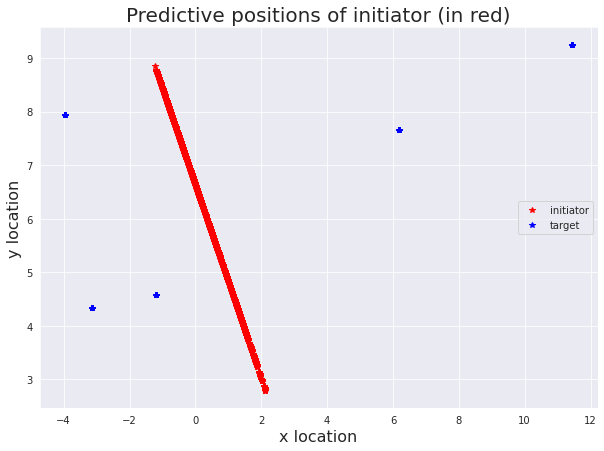

In [110]:
plt.figure(figsize=(10, 7))
plt.plot(predic_position['loc_initiator_x'],predic_position['loc_initiator_y'],'*r',label='initiator')
plt.plot(data_for_pred['loc_target_x'],data_for_pred['loc_target_y'],"*b", label='target')
plt.xlabel("x location", fontsize=16)
plt.ylabel("y location", fontsize=16)
plt.legend(loc='center right', bbox_to_anchor=(1, 0.5))
plt.title('Predictive positions of initiator (in red)', fontsize=20);

In [155]:
from sklearn.metrics import accuracy_score
list_variable=list(data_for_pred.columns)
list_variable_tabou=list_variable
variable=[]
score=0
data_for_pred=data_for_pred.sample(frac=1).reset_index(drop=True)
while len(list_variable_tabou)>0:
    y=data_for_pred[['loc_initiator_x','loc_initiator_y']]
    variable_en_cour=False
    for i in list_variable_tabou:
        X=data_for_pred[variable+[i]]
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        clf = RandomForestRegressor()
        clf= clf.fit(x_train, y_train)
        score_test=clf.score(x_test,y_test)
    if score_test>score:
        score=score_test
        variable_en_cour=i
    if not(variable_en_cour):
        list_variable_tabou=[]
    else:
        variable.append(variable_en_cour)
        del list_variable_tabou[list_variable_tabou.index(variable_en_cour)]
    print(variable_en_cour,score)

orientation 0.002814468664887493
False 0.002814468664887493


Cet algo me dit qu'il faut garder juste orientation... Ça semble faux.

In [112]:
reg = RandomForestRegressor()
sfs = SequentialFeatureSelector(reg, direction='forward')
sfs.fit(X_train, Y_train)

SequentialFeatureSelector(estimator=RandomForestRegressor())

In [159]:
var_select = sfs.get_support()
list_var_select=['loc_initiator_x','loc_initiator_y']
list_variable = X_train.columns.to_list()
for i in range(len(list_variable)) :
    if var_select[i]:
        list_var_select.append(list_variable[i])
        print(list_variable[i])

tof
tof_skew
range
range_skew
loc_target_x
loc_target_y
loc_target_z
temperature_initiator
temperature_target
orientation


#### Deuxième modèle avec les variables sélectionnées : nlos_indicator, skew, tof, tof_skew, loc_target_y, rssi_data,rssi_mean

In [160]:
data_for_pred_select = data_for_pred[list_var_select]

In [161]:
#ceration of test and train with selected variables
test,train = train_test_split(data_for_pred_select, test_size=0.3, train_size=0.7, shuffle=True)
Y_train = train[['loc_initiator_x', 'loc_initiator_y']]
X_train = train.drop(["loc_initiator_x",'loc_initiator_y'], axis=1, inplace=False)

Y_test = test[['loc_initiator_x', 'loc_initiator_y']]
X_test = test.drop(["loc_initiator_x",'loc_initiator_y'], axis=1, inplace=False)

In [162]:
reg = RandomForestRegressor()
reg = reg.fit(X_train, Y_train)
predic_rf_2=reg.predict(X_test)
reg.score(X_test,Y_test)

0.9829291008543619

In [167]:
np.sqrt(mean_squared_error(Y_test,predic_rf_2))

0.18580858368726327

In [168]:
mean_absolute_error(Y_test,predic_rf_2)

0.11392514342453675

In [164]:
score_distanceM(Xobserve = Y_test['loc_initiator_x'],
                Yobserve = Y_test['loc_initiator_y'],
                Xprevu = predic_rf_2[:,0],
                Yprevu = predic_rf_2[:,1])

0.16759230540769005

In [165]:
predic_position_2 = pd.DataFrame(predic_rf_2, columns=['loc_initiator_x','loc_initiator_y'])

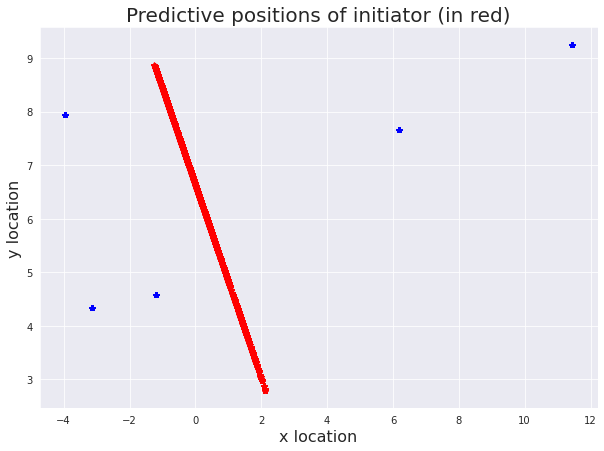

In [120]:
plt.figure(figsize=(10, 7))
plt.plot(predic_position_2['loc_initiator_x'],predic_position_2['loc_initiator_y'],'*r')
plt.plot(data_for_pred['loc_target_x'],data_for_pred['loc_target_y'],"*b")
plt.xlabel("x location", fontsize=16)
plt.ylabel("y location", fontsize=16)
plt.title('Predictive positions of initiator (in red)', fontsize=20);

### Validation croisée

In [121]:
Y = data_for_pred[['loc_initiator_x', 'loc_initiator_y']]
X = data_for_pred.drop(["loc_initiator_x",'loc_initiator_y'], axis=1, inplace=False)

In [122]:
reg = RandomForestRegressor()
cross_val_score(reg, X, Y, cv=5)

array([0.98294727, 0.98387906, 0.98085585, 0.98312538, 0.98559146])

## <center>Affichage du score de RandomForest en fonction des paramètres</center>

#### On va faire varier n_estimators qui correspond au nombre d'arbres de décisions utilisés.

In [123]:
scores_estimators = []

In [124]:
reg_50 = RandomForestRegressor(n_estimators = 1)
reg_50 = reg_50.fit(X_train, Y_train)
scores_estimators.append(reg_50.score(X_test,Y_test))

In [125]:
reg_100 = RandomForestRegressor(n_estimators = 100)
reg = reg_100.fit(X_train, Y_train)
scores_estimators.append(reg_100.score(X_test,Y_test))

In [126]:
reg_150 = RandomForestRegressor(n_estimators = 150)
reg_150 = reg_150.fit(X_train, Y_train)
scores_estimators.append(reg_150.score(X_test,Y_test))

In [127]:
reg_200 = RandomForestRegressor(n_estimators = 200)
reg_200 = reg_200.fit(X_train, Y_train)
scores_estimators.append(reg_200.score(X_test,Y_test))

In [128]:
scores_estimators

[0.9486673129696435,
 0.9770360738010422,
 0.9769944005116884,
 0.9771612492514468]

/home/sid2019-6/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scores with different number of trees')

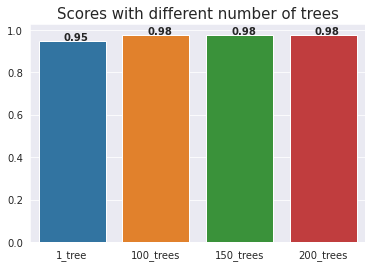

In [129]:
sns.barplot(['1_tree','100_trees','150_trees', '200_trees'],scores_estimators)
plt.text(-0.1, round(scores_estimators[0],2), round(scores_estimators[0],2), horizontalalignment='left', weight='semibold')
plt.text(0.9,round(scores_estimators[1],2), round(scores_estimators[1],2), horizontalalignment='left', weight='semibold')
plt.text(1.9, round(scores_estimators[2],2), round(scores_estimators[2],2), horizontalalignment='left', weight='semibold')
plt.text(2.9, round(scores_estimators[3],2), round(scores_estimators[3],2), horizontalalignment='left', weight='semibold')
plt.title("Scores with different number of trees",fontsize=15)

À partir de 100 arbres, le score ne change plus. 100 arbres est la valeur par défaut de RandomForest

#### On va faire varier max_depth qui correspond au nombre d'arbres de décisions utilisés.

In [130]:
scores_depth = []

In [131]:
reg_3 = RandomForestRegressor(max_depth = 3)
reg_3 = reg_3.fit(X_train, Y_train)
scores_depth.append(reg_3.score(X_test,Y_test))

In [132]:
reg_15 = RandomForestRegressor(max_depth = 6)
reg_15 = reg_15.fit(X_train, Y_train)
scores_depth.append(reg_15.score(X_test,Y_test))

In [133]:
reg_30 = RandomForestRegressor(max_depth = 9)
reg_30 = reg_30.fit(X_train, Y_train)
scores_depth.append(reg_30.score(X_test,Y_test))

In [134]:
reg_300 = RandomForestRegressor(max_depth = 12)
reg_300 = reg_300.fit(X_train, Y_train)
scores_depth.append(reg_300.score(X_test,Y_test))

/home/sid2019-6/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scores with different maximum depth')

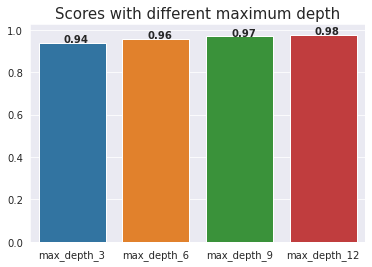

In [135]:
sns.barplot(['max_depth_3','max_depth_6','max_depth_9','max_depth_12'],scores_depth)
plt.text(-0.1, round(scores_depth[0],2), round(scores_depth[0],2), horizontalalignment='left', weight='semibold')
plt.text(0.9,round(scores_depth[1],2), round(scores_depth[1],2), horizontalalignment='left', weight='semibold')
plt.text(1.9, round(scores_depth[2],2), round(scores_depth[2],2), horizontalalignment='left', weight='semibold')
plt.text(2.9, round(scores_depth[3],2), round(scores_depth[3],2), horizontalalignment='left', weight='semibold')
plt.title("Scores with different maximum depth",fontsize=15)

#### On va faire varier max_depth et n_estimators en même temps 

In [136]:
list_estimators = [1,100,150,200]
list_depth = [3,6,9,12]

In [137]:
dic_score = {} #{max_depth : n_estimators}
for i in range(len(list_estimators)):
    n_estimator = list_estimators[i]
    list_score = []
    for j in range(len(list_estimators)):
        max_depth = list_depth[j]
        reg = RandomForestRegressor(max_depth = max_depth,n_estimators=n_estimator)
        reg = reg.fit(X_train, Y_train)
        list_score.append(reg.score(X_test,Y_test))
    dic_score[n_estimator]=list_score

In [138]:
dic_score

{1: [0.9355727234692016,
  0.9446478315112572,
  0.9470611018698167,
  0.9475373681940766],
 100: [0.9392821882545387,
  0.9587129779662993,
  0.9724803553262511,
  0.9762079291414989],
 150: [0.9383721013770535,
  0.9590397470686223,
  0.972542669554783,
  0.976987527407264],
 200: [0.9396201776919233,
  0.9586763112271939,
  0.9727263307352566,
  0.9765692035468316]}

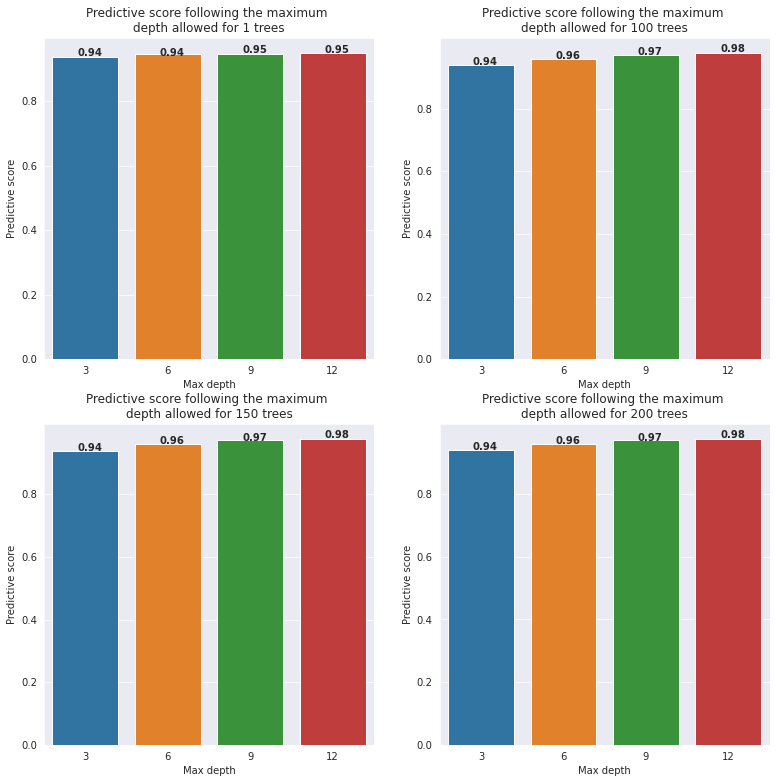

In [153]:
fig = plt.figure(figsize=(13,13))
i=1
for key in dic_score.keys() :
    ax = fig.add_subplot(2,2,i)
    bar1 = sns.barplot(x = list_depth,
                       y = dic_score[key])  
    plt.text(-0.1, round(dic_score[key][0],2), round(dic_score[key][0],2), horizontalalignment='left', weight='semibold')
    plt.text(0.9,round(dic_score[key][1],2), round(dic_score[key][1],2), horizontalalignment='left', weight='semibold')
    plt.text(1.9, round(dic_score[key][2],2), round(dic_score[key][2],2), horizontalalignment='left', weight='semibold')
    plt.text(2.9, round(dic_score[key][3],2), round(dic_score[key][3],2), horizontalalignment='left', weight='semibold')
    ax.set_xlabel("Max depth")       
    ax.set_ylabel("Predictive score")     
    ax.set_yticks(np.arange(0, 1,0.2))       
    ax.set_title("Predictive score following the maximum \ndepth allowed for "+str(key)+" trees")   
    i+=1

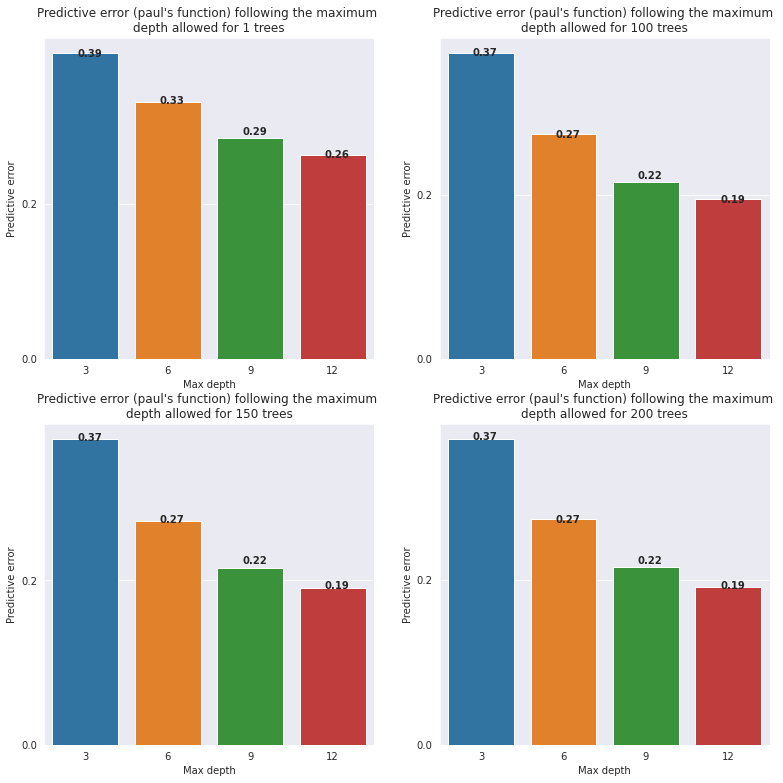

In [140]:
fig = plt.figure(figsize=(13,13))
k=1
for i in range(len(list_estimators)):
    n_estimator = list_estimators[i]
    list_erreur= []
    for j in range(len(list_depth)):
        max_depth = list_depth[j]
        reg = RandomForestRegressor(max_depth = max_depth,n_estimators=n_estimator)
        reg = reg.fit(X_train, Y_train)
        predic=reg.predict(X_test)
        list_erreur.append(score_distanceM(Xobserve = Y_test['loc_initiator_x'],
                Yobserve = Y_test['loc_initiator_y'],
                Xprevu = predic[:,0],
                Yprevu = predic[:,1]))
    ax = fig.add_subplot(2,2,k)
    bar = sns.barplot(x = list_depth,
                      y = list_erreur)  
    plt.text(-0.1, round(list_erreur[0],2), round(list_erreur[0],2), horizontalalignment='left', weight='semibold')
    plt.text(0.9,round(list_erreur[1],2), round(list_erreur[1],2), horizontalalignment='left', weight='semibold')
    plt.text(1.9, round(list_erreur[2],2), round(list_erreur[2],2), horizontalalignment='left', weight='semibold')
    plt.text(2.9, round(list_erreur[3],2), round(list_erreur[3],2), horizontalalignment='left', weight='semibold')
    ax.set_xlabel("Max depth")       
    ax.set_ylabel("Predictive error")     
    ax.set_yticks(np.arange(0, max(list_erreur),0.2))       
    ax.set_title("Predictive error (paul's function) following the maximum \ndepth allowed for "+str(n_estimator)+" trees")   
    k+=1

Le maximum de profondeur a un effet sur la prédiction alors que le nombre d'arbre n'a pas beaucoup d'influence. Globalement, on observe la même évolution que ce soit pour 1 arbre ou 200 mais le score augment quand on augmente le maximum de profondeur.

In [141]:
from sklearn.model_selection import GridSearchCV

In [142]:
parameters = {'max_depth':[3,6,9,12,20,30],
              'n_estimators':[1,100,150,200]}
reg = RandomForestRegressor()
clf = GridSearchCV(reg, parameters)
clf.fit(X, Y)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 6, 9, 12, 20, 30],
                         'n_estimators': [1, 100, 150, 200]})

In [143]:
clf.cv_results_

{'mean_fit_time': array([0.01681643, 0.74471698, 1.07946811, 1.32736211, 0.01426663,
        1.12320642, 1.74438462, 2.31482205, 0.02173562, 1.5599813 ,
        2.4201685 , 3.06949368, 0.02137289, 1.83146319, 2.67337604,
        3.45837278, 0.0207952 , 1.89006376, 2.74737082, 3.51032658,
        0.02954912, 1.74154844, 2.62335048, 3.46676412]),
 'std_fit_time': array([0.00117024, 0.06857795, 0.09725745, 0.07650705, 0.0002355 ,
        0.04805734, 0.13377413, 0.033876  , 0.00112847, 0.0443622 ,
        0.06246358, 0.06533691, 0.00091975, 0.02482095, 0.07883652,
        0.09560448, 0.00098502, 0.11132622, 0.1093986 , 0.11726258,
        0.00031512, 0.03801744, 0.06316393, 0.03938975]),
 'mean_score_time': array([0.00453448, 0.01224141, 0.01509771, 0.01931057, 0.00260129,
        0.01283255, 0.01646204, 0.02306461, 0.00339952, 0.01594276,
        0.0230639 , 0.02701011, 0.00268369, 0.01754932, 0.02405558,
        0.03256073, 0.00239449, 0.01805382, 0.02426057, 0.03309493,
        0.003425

In [149]:
params_opti = clf.cv_results_['params'][clf.best_index_]
params_opti

{'max_depth': 30, 'n_estimators': 150}

### Test avec les paramètres optimaux

In [150]:
test,train = train_test_split(data_for_pred, test_size=0.25, train_size=0.75, shuffle=True)
Y_train = train[['loc_initiator_x', 'loc_initiator_y']]
X_train = train.drop(["loc_initiator_x",'loc_initiator_y'], axis=1, inplace=False)

Y_test = test[['loc_initiator_x', 'loc_initiator_y']]
X_test = test.drop(["loc_initiator_x",'loc_initiator_y'], axis=1, inplace=False)

In [151]:
reg = RandomForestRegressor(max_depth = params_opti['max_depth'], n_estimators = params_opti['n_estimators'])
reg = reg.fit(X_train, Y_train)
predic_rf_opti=reg.predict(X_test)
reg.score(X_test,Y_test)

0.9650327900392701

In [152]:
score_distanceM(Xobserve = Y_test['loc_initiator_x'],
                Yobserve = Y_test['loc_initiator_y'],
                Xprevu = predic_rf_opti[:,0],
                Yprevu = predic_rf_opti[:,1])

0.2428475423418029